In [ ]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 4.9MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from gensim import models
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# **Features generation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
testdf = pd.read_csv('/content/taskB_SDP_test.csv')
testdf

,unique_id,core_id,citing_title,citing_author,cited_title,cited_author,citation_context
0,CCT1,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,The English village community examined in its ...,Seebohm,"In historical research, regressive methods mov..."
1,CCT2,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,Die italienischen Begr nder der Wiener Donauka...,Slezak,"For example, a new cut-off channel at the Dona..."
2,CCT3,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,Wien im Bild historischer Karten Die Entwicklu...,Opll,It can be considered as the first map of the V...
3,CCT4,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,The hydraulic geometry of stream channels and ...,Leopold,According to the ''hydraulic geometry'' approa...
4,CCT5,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,From memory to written record,Clanchy,Historians ask for the motivation and interest...
...,...,...,...,...,...,...,...
995,CCT996,187054964,Clinical Study Peritoneal Dialysis as a First ...,Roberto Barone,Survival of functionally anuric patients on au...,Brown,"In contrast, in the NECOSAD study, the authors..."
996,CCT997,189217163,The trajectory of neurotoxic side effects' imp...,Jenny Drott,Incidence prevalence and predictors of chemoth...,Seretny,Oxaliplatin can cause acute and chronic neurot...
997,CCT998,189217163,The trajectory of neurotoxic side effects' imp...,Jenny Drott,Long term course of oxaliplatin induced polyne...,Briani,The finding that neurotoxicity influences the ...
998,CCT999,189217163,The trajectory of neurotoxic side effects' imp...,Jenny Drott,Impact of oxaliplatin induced neuropathy a pat...,Bennett,The finding that neurotoxicity influences the ...


In [ ]:
## feature F14
citance_len = []
citedtit_len = []
for i in testdf.index:
  citance_len.append(len(testdf.iloc[i]['citation_context'].split()))
  citedtit_len.append(len(testdf.iloc[i]['cited_title'].split()))
testdf['citation length'] = citance_len
testdf['cited title length'] = citedtit_len

In [ ]:
## feature F2
auth_freq = []
for i in testdf.index:
  if(testdf.iloc[i]['citing_author']==testdf.iloc[i]['cited_author']):
    auth_freq.append(True)
  else:
    auth_freq.append(False)

testdf['self_citation'] = auth_freq

In [ ]:
## feature F9
cosine_tfidf_tit = []
for i in testdf.index:
  citing_tit = testdf.iloc[i]['citing_title']
  cited_tit = testdf.iloc[i]['cited_title']
  corpus=[cited_tit,citing_tit]
  vect = TfidfVectorizer(stop_words="english")
  tfidf = vect.fit_transform(corpus)
  # print(tfidf.toarray())
  # print(tfidf.T.toarray())
  tf = tfidf*tfidf.T
  tf = tf.toarray()
  # print(tf[0][1])
  cosine_tfidf_tit.append(tf[0][1])

testdf['tfidf_titles'] = cosine_tfidf_tit

In [ ]:
## feature F13
cosine_tfidf_citance_citedtit = []
for i in testdf.index:
  citance = testdf.iloc[i]['citation_context']
  cited_tit = testdf.iloc[i]['cited_title']
  corpus=[cited_tit,citance]
  vect = TfidfVectorizer(stop_words="english")
  tfidf = vect.fit_transform(corpus)
  # print(tfidf.toarray())
  # print(tfidf.T.toarray())
  tf = tfidf*tfidf.T
  tf = tf.toarray()
  # print(tf[0][1])
  cosine_tfidf_citance_citedtit.append(tf[0][1])

testdf['tfidf_citance_citedtitle'] = cosine_tfidf_citance_citedtit

In [ ]:
def cleaning_text(text):
  text_tokens = word_tokenize(text)
  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
  tokens = [word for word in tokens_without_sw if word.isalnum()]

  return tokens 

In [ ]:
len(titles_keyword_match)

2297

In [ ]:
## feature F20 = no. of distinct words matching = once confirm it!!
nltk.download('punkt')
nltk.download('stopwords')

titles_keyword_match = []
citance_citedtit_keyword_match = []

for i in tqdm(testdf.index):
  citingtit = testdf.iloc[i]['citing_title']
  citedtit = testdf.iloc[i]['cited_title']
  citance = testdf.iloc[i]['citation_context']

  citingtit = set(cleaning_text(citingtit))
  citedtit = set(cleaning_text(citedtit))
  citance = set(cleaning_text(citance))

  titles_keyword_match.append(len(citingtit.intersection(citedtit)))
  citance_citedtit_keyword_match.append(len(citance.intersection(citedtit)))

testdf['citance cited title keyword match'] = citance_citedtit_keyword_match
testdf['citing cited titles keyword match'] = titles_keyword_match

  0%|          | 0/1000 [00:00<?, ?it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100%|██████████| 1000/1000 [04:24<00:00,  3.77it/s]


In [ ]:
## feature F23+25
stop_words = stopwords.words('english')

wmd_titles=[]
wmd_citance_citedtit=[]

if not os.path.exists('/content/drive/MyDrive/3C 2021 shared tasks/3C Task B data/GoogleNews-vectors-negative300.bin.gz'):
    raise ValueError("SKIP: You need to download the google news model")
    
model = models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/3C 2021 shared tasks/3C Task B data/GoogleNews-vectors-negative300.bin.gz', binary=True)

for i in tqdm(testdf.index):
  
  citingtit = testdf.iloc[i]['citing_title'].lower()
  citingtit = re.sub(r'[^\w\s]', '', citingtit).split()
  citedtit = testdf.iloc[i]['cited_title'].lower()
  citedtit = re.sub(r'[^\w\s]', '', citedtit).split()
  citance = testdf.iloc[i]['citation_context'].lower()
  citance = re.sub(r'[^\w\s]', '', citance).split()

  citingtit = [w for w in citingtit if w not in stop_words]
  citedtit = [w for w in citedtit if w not in stop_words]
  citance = [w for w in citance if w not in stop_words]

  wmd_citance_citedtit.append(model.wmdistance(citedtit, citance))
  wmd_titles.append(model.wmdistance(citedtit, citingtit))

testdf['wmd_titles'] = wmd_titles
testdf['wmd_citance_cited_title'] = wmd_citance_citedtit

100%|██████████| 1000/1000 [00:05<00:00, 177.69it/s]


In [ ]:
scores

{'compound': 0.25, 'neg': 0.0, 'neu': 0.882, 'pos': 0.118}

In [ ]:
## feature F28  VADER sentiment for citance
analyser = SentimentIntensityAnalyzer()

vad_pos=[]
vad_neg=[]
vad_neu=[]
vad_com=[]

# print(analyser.polarity_scores('I am worst, best'))
for i in tqdm(testdf.index):
  citance = testdf.iloc[i]['citation_context']
  scores = analyser.polarity_scores(citance)
  vad_pos.append(scores['pos'])
  vad_neg.append(scores['neg'])
  vad_neu.append(scores['neu'])
  vad_com.append(scores['compound'])

testdf['vad_pos'] = vad_pos
testdf['vad_neg'] = vad_neg
testdf['vad_neu'] = vad_neu
testdf['vad_com'] = vad_com

100%|██████████| 1000/1000 [00:00<00:00, 2228.19it/s]


In [ ]:
df

,unique_id,core_id,citing_title,citing_author,cited_title,cited_author,citation_context
0,CCT1,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,The English village community examined in its ...,Seebohm,"In historical research, regressive methods mov..."
1,CCT2,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,Die italienischen Begr nder der Wiener Donauka...,Slezak,"For example, a new cut-off channel at the Dona..."
2,CCT3,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,Wien im Bild historischer Karten Die Entwicklu...,Opll,It can be considered as the first map of the V...
3,CCT4,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,The hydraulic geometry of stream channels and ...,Leopold,According to the ''hydraulic geometry'' approa...
4,CCT5,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,From memory to written record,Clanchy,Historians ask for the motivation and interest...
...,...,...,...,...,...,...,...
995,CCT996,187054964,Clinical Study Peritoneal Dialysis as a First ...,Roberto Barone,Survival of functionally anuric patients on au...,Brown,"In contrast, in the NECOSAD study, the authors..."
996,CCT997,189217163,The trajectory of neurotoxic side effects' imp...,Jenny Drott,Incidence prevalence and predictors of chemoth...,Seretny,Oxaliplatin can cause acute and chronic neurot...
997,CCT998,189217163,The trajectory of neurotoxic side effects' imp...,Jenny Drott,Long term course of oxaliplatin induced polyne...,Briani,The finding that neurotoxicity influences the ...
998,CCT999,189217163,The trajectory of neurotoxic side effects' imp...,Jenny Drott,Impact of oxaliplatin induced neuropathy a pat...,Bennett,The finding that neurotoxicity influences the ...


In [ ]:
testdf

,unique_id,core_id,citing_title,citing_author,cited_title,cited_author,citation_context,citation length,cited title length,self_citation,tfidf_titles,tfidf_citance_citedtitle,citance cited title keyword match,citing cited titles keyword match,wmd_titles,wmd_citance_cited_title,vad_pos,vad_neg,vad_neu,vad_com
0,CCT1,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,The English village community examined in its ...,Seebohm,"In historical research, regressive methods mov...",44,29,False,0.000000,0.000000,0,0,3.295124,3.325429,0.063,0.000,0.937,0.4404
1,CCT2,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,Die italienischen Begr nder der Wiener Donauka...,Slezak,"For example, a new cut-off channel at the Dona...",35,7,False,0.000000,0.000000,0,0,3.798572,3.951583,0.000,0.000,1.000,0.0000
2,CCT3,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,Wien im Bild historischer Karten Die Entwicklu...,Opll,It can be considered as the first map of the V...,26,15,False,0.000000,0.000000,0,0,4.096225,4.221632,0.000,0.000,1.000,0.0000
3,CCT4,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,The hydraulic geometry of stream channels and ...,Leopold,According to the ''hydraulic geometry'' approa...,19,10,False,0.000000,0.130481,1,0,3.319990,2.602660,0.000,0.000,1.000,0.0000
4,CCT5,81153632,"Two steps back, one step forward: reconstructi...",Severin Hohensinner,From memory to written record,Clanchy,Historians ask for the motivation and interest...,21,5,False,0.000000,0.000000,0,0,3.342970,3.444389,0.256,0.000,0.744,0.6369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,CCT996,187054964,Clinical Study Peritoneal Dialysis as a First ...,Roberto Barone,Survival of functionally anuric patients on au...,Brown,"In contrast, in the NECOSAD study, the authors...",62,14,False,0.151778,0.401136,5,1,2.510665,2.338875,0.034,0.089,0.877,-0.5719
996,CCT997,189217163,The trajectory of neurotoxic side effects' imp...,Jenny Drott,Incidence prevalence and predictors of chemoth...,Seretny,Oxaliplatin can cause acute and chronic neurot...,17,15,False,0.000000,0.000000,0,0,3.750646,3.908886,0.000,0.153,0.847,-0.4404
997,CCT998,189217163,The trajectory of neurotoxic side effects' imp...,Jenny Drott,Long term course of oxaliplatin induced polyne...,Briani,The finding that neurotoxicity influences the ...,52,14,False,0.059930,0.051425,2,1,3.091636,2.975275,0.113,0.000,0.887,0.7469
998,CCT999,189217163,The trajectory of neurotoxic side effects' imp...,Jenny Drott,Impact of oxaliplatin induced neuropathy a pat...,Bennett,The finding that neurotoxicity influences the ...,52,8,False,0.078745,0.068955,1,0,3.390623,3.499854,0.113,0.000,0.887,0.7469


In [ ]:
testdf.to_csv('/content/test_full_titles_features.csv')

In [ ]:
df.iloc[2]

unique_id                                                                          CC3
core_id                                                                      158977742
citing_title                         Ontology-Based Recommendation of Editorial Pro...
citing_author                                                 Thiviyan Thanapalasingam
cited_title                          Klink-2: Integrating Multiple Web Sources to G...
cited_author                                                                   Osborne
citation_context                     In order to do so, we characterized all SN pub...
citation_influence_label                                                             0
citation length                                                                     32
cited title length                                                                  10
self_citation                                                                    False
tfidf_titles                               

In [ ]:
df.iloc[2]['citing_title']

'Ontology-Based Recommendation of Editorial Products'

In [ ]:
df.iloc[2]['cited_title']

'Klink-2: Integrating Multiple Web Sources to Generate Semantic Topic Networks'

In [ ]:
df.iloc[2]['citation_context']

'In order to do so, we characterized all SN publications according to their associated research topics by exploiting the Computer Science Ontology (CSO), a large-scale automatically generated taxonomy of research areas #AUTHOR_TAG'

# **Training ML models**

In [ ]:
df_tr = pd.read_csv('/content/train_features_orig.csv')
df_te = pd.read_csv('/content/test_features_orig.csv')
# df_sbert_tr = pd.read_csv('/content/train_features_orig.csv')
# df_sbert_te = pd.read_csv('/content/test_features_orig.csv')

In [ ]:
df_tr = df_tr.drop('Unnamed: 0',axis='columns')
df_te = df_te.drop('Unnamed: 0',axis='columns')

In [ ]:
df_tr[df_tr.columns[2:]]

,tfidf,wmd,vad_pos,vad_neg,vad_neu,vad_com,citation length,cited title length,self_citation,tfidf_citance_citedtitle,citance cited title keyword match,citing cited titles keyword match,wmd_titles,wmd_citance_cited_title
0,0.0,0.380332,0.118,0.000,0.882,0.2500,16.0,7.0,False,0.136276,1.0,0.0,3.926372,3.020933
1,0.0,0.497124,0.071,0.000,0.929,0.2500,27.0,5.0,False,0.061214,1.0,0.0,3.795031,3.535336
2,0.0,0.429995,0.000,0.086,0.914,-0.4404,32.0,10.0,False,0.000000,0.0,0.0,3.806394,3.252318
3,0.0,0.351009,0.143,0.000,0.857,0.8020,59.0,8.0,False,0.121344,0.0,0.0,3.666979,3.303668
4,0.0,0.363511,0.068,0.000,0.932,0.4019,38.0,9.0,False,0.000000,0.0,0.0,3.474603,3.466395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3460,0.0,0.426368,0.057,0.000,0.943,0.7050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3461,0.0,0.529257,0.018,0.026,0.956,-0.1531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3462,0.0,0.551311,0.000,0.051,0.949,-0.7783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3463,0.0,0.549680,0.000,0.000,1.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_tr = df_tr.replace([np.inf, -np.inf], np.nan)
df_tr = df_tr.dropna()

y = df_tr['label'] 
X = df_tr[df_tr.columns[2:]]

# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
classifier_names = ["Logistic Regression", "KNN", "Random Forest","SVM","Decision Tree","xgboost"]

classifiers = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), LinearSVC(), DecisionTreeClassifier(), XGBClassifier()]

zipped_clf = zip(classifier_names,classifiers)

In [ ]:
def classifier(classifier, t_train, c_train, t_test, c_test):
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('standardize', StandardScaler()),                         
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_acc = fit_classifier(checker_pipeline, t_train, c_train, t_test,c_test)
        result.append((n,clf_acc))
    return result

In [ ]:
def fit_classifier(pipeline, x_train, y_train, x_test, y_test):
    model_fit = pipeline.fit(x_train, y_train)
    y_pred = model_fit.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1_macro = metrics.f1_score(y_test, y_pred,average='macro')
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("f1 score: {0:.3f}%".format(f1_macro*100))
    return (accuracy,f1_macro)

In [ ]:
result = classifier(zipped_clf, x_train, y_train, x_test, y_test)

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy score: 50.11%
f1 score: 49.130%
Validation result for KNN
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
accuracy score: 54.00%
f1 score: 53.704%
Validation result for Random Forest
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
             

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy score: 55.78%
f1 score: 55.707%
Validation result for xgboost
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
accuracy score: 53.33%
f1 score: 53.152%


In [ ]:
df_tr[df_tr.columns[8:]]

,citation length,cited title length,self_citation,tfidf_titles,tfidf_citance_citedtitle,citance cited title keyword match,citing cited titles keyword match,wmd_titles,wmd_citance_cited_title,vad_pos,vad_neg,vad_neu,vad_com
0,16,7,False,0.000000,0.136276,1,0,3.926372,3.020933,0.118,0.000,0.882,0.2500
1,27,5,False,0.000000,0.061214,1,0,3.795031,3.535336,0.071,0.000,0.929,0.2500
2,32,10,False,0.000000,0.000000,0,0,3.806394,3.252318,0.000,0.086,0.914,-0.4404
3,59,8,False,0.000000,0.121344,0,0,3.666979,3.303668,0.143,0.000,0.857,0.8020
4,38,9,False,0.000000,0.000000,0,0,3.474603,3.466395,0.068,0.000,0.932,0.4019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,34,6,False,0.000000,0.000000,0,0,3.676562,3.811690,0.060,0.000,0.940,0.2732
2996,26,33,False,0.104289,0.000000,0,2,3.034470,3.270260,0.000,0.000,1.000,0.0000
2997,42,5,False,0.000000,0.000000,0,0,3.571797,3.801721,0.072,0.000,0.928,0.4927
2998,34,6,False,0.000000,0.000000,0,0,3.324595,3.584953,0.000,0.153,0.847,-0.7003


In [ ]:
y=df_tr['label'] 
df_trx = df_tr[df_tr.columns[2:]]
data = df_trx.values[:, :]
# perform a robust scaler transform of the dataset
trans = StandardScaler()
data = trans.fit_transform(data)
# convert the array back to a dataframe
dataset = pd.DataFrame(data)

X=dataset.loc[:,:]


# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=400/3000)

In [ ]:
x_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
1798,-0.695435,-0.796281,-0.826416,0.403555,0.419776,-1.595360,1.478888,0.057539,0.0,0.071834,1.901203,-0.571849,0.714824,-0.950692
566,-0.695435,0.431014,-0.195739,0.779947,-0.325107,-0.565184,0.656257,-1.703260,0.0,-0.780506,-0.707080,-0.571849,-0.321903,-0.121960
1397,-0.695435,0.130414,1.668868,1.030875,-2.003872,0.221112,-0.546051,1.035760,0.0,-0.780506,-0.707080,-0.571849,0.535919,-0.230303
732,-0.217897,0.345628,-0.826416,1.944969,-0.536342,-2.081317,0.592977,0.448827,0.0,0.527755,1.901203,-0.571849,-0.610813,-0.889424
2706,-0.035481,-0.292717,-0.826416,-0.564310,1.020129,-0.300421,-1.052285,0.057539,0.0,-0.780506,-0.707080,1.733224,-0.571156,1.004129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,1.909256,3.898554,0.887378,-0.564310,-0.369577,1.015915,-0.672609,-0.138106,0.0,-0.780506,-0.707080,-0.571849,-1.719438,0.290143
1140,-0.695435,-0.554088,-0.291712,-0.564310,0.586540,0.519904,1.478888,-0.333750,0.0,-0.396966,-0.707080,-0.571849,1.191597,0.574241
68,0.087256,-0.255930,-0.826416,-0.564310,1.020129,-0.300421,0.086743,0.644471,0.0,-0.273868,0.162347,-0.571849,-0.817966,-0.387663
2272,0.499672,0.215731,0.064757,0.206397,-0.180577,0.158208,-0.229654,-0.725038,0.0,0.881345,-0.707080,0.580688,-0.027410,0.082145


In [ ]:
# clf=RandomForestClassifier(n_estimators=100)
clf = DecisionTreeClassifier()

clf.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
dataset.loc[:,:]

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.178844,-0.725038,0.0,-0.695435,0.835748,0.162347,-0.571849,1.177359,-0.887570,0.791406,-0.564310,-0.291754,0.344083
1,-0.482771,-1.116327,0.0,-0.695435,-0.054498,0.162347,-0.571849,0.896769,0.365041,0.147019,-0.564310,0.230776,0.344083
2,-0.166375,-0.138106,0.0,-0.695435,-0.780506,-0.707080,-0.571849,0.921043,-0.324130,-0.826416,0.977104,0.064011,-1.435781
3,1.542167,-0.529394,0.0,-0.695435,0.658643,-0.707080,-0.571849,0.623206,-0.199090,1.134165,-0.564310,-0.569695,1.767150
4,0.213301,-0.333750,0.0,-0.695435,-0.780506,-0.707080,-0.571849,0.212225,0.197163,0.105888,-0.564310,0.264128,0.735685
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,-0.039816,-0.920683,0.0,-0.695435,-0.780506,-0.707080,-0.571849,0.643679,1.037982,-0.003794,-0.564310,0.353070,0.403893
2995,-0.546051,4.361712,0.0,0.530927,-0.780506,-0.707080,1.733224,-0.728049,-0.280441,-0.826416,-0.564310,1.020129,-0.300421
2996,0.466419,-1.116327,0.0,-0.695435,-0.780506,-0.707080,-0.571849,0.419864,1.013707,0.160730,-0.564310,0.219658,0.969769
2997,-0.039816,-0.920683,0.0,-0.695435,-0.780506,-0.707080,-0.571849,-0.108243,0.485862,-0.826416,2.177974,-0.680872,-2.105808


In [ ]:
y_pred=clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("f1:",metrics.f1_score(y_test, y_pred,average='macro'))

Accuracy: 0.5375
f1: 0.5374277230817315


In [ ]:
cm=metrics.confusion_matrix(y_test,y_pred)
cm

array([[110, 103],
       [ 82, 105]])

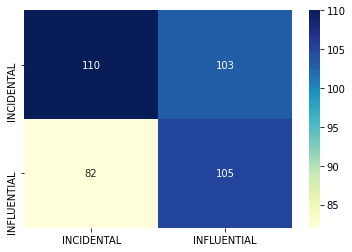

In [ ]:
df_cm = pd.DataFrame(cm, index = ['INCIDENTAL','INFLUENTIAL'],
                  columns = ['INCIDENTAL','INFLUENTIAL'])
# plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='d')

In [ ]:
feature_imp = pd.Series(clf.feature_importances_,index=df_tr.columns[2:]).sort_values(ascending=False)
feature_imp

wmd_titles                           0.152014
wmd_citance_cited_title              0.144243
wmd                                  0.134579
citation length                      0.094303
cited title length                   0.091349
tfidf_citance_citedtitle             0.080861
vad_com                              0.053899
vad_pos                              0.051301
tfidf                                0.049036
vad_neu                              0.047235
vad_neg                              0.041947
citance cited title keyword match    0.032134
citing cited titles keyword match    0.027100
self_citation                        0.000000
dtype: float64

No handles with labels found to put in legend.


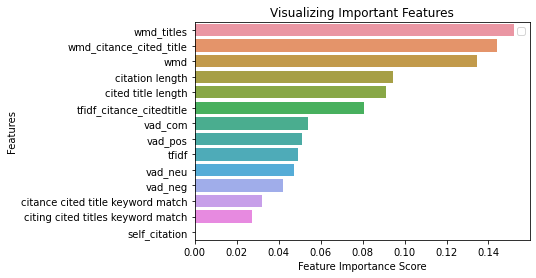

In [ ]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
df_te.columns[1:]

Index(['tfidf', 'wmd', 'vad_pos', 'vad_neg', 'vad_neu', 'vad_com',
       'citation length', 'cited title length', 'self_citation',
       'tfidf_citance_citedtitle', 'citance cited title keyword match',
       'citing cited titles keyword match', 'wmd_titles',
       'wmd_citance_cited_title'],
      dtype='object')

In [ ]:
df_te.replace([np.inf, -np.inf], 100)['wmd_citance_cited_title'].value_counts()

100.000000    2
3.026566      1
3.716916      1
2.771583      1
3.626371      1
             ..
3.820096      1
3.607833      1
2.750612      1
2.888618      1
3.821147      1
Name: wmd_citance_cited_title, Length: 999, dtype: int64

In [ ]:
df_te['wmd_citance_cited_title'].value_counts()

inf         2
3.000038    1
3.764980    1
3.259686    1
3.566216    1
           ..
3.116919    1
3.453224    1
2.942267    1
3.643249    1
3.418417    1
Name: wmd_citance_cited_title, Length: 999, dtype: int64

In [ ]:
df_te = df_te.replace([np.inf, -np.inf], 100)
data_test = df_te.values[:, 1:]
# perform a robust scaler transform of the dataset
trans = StandardScaler()
data_test = trans.fit_transform(data_test)
# convert the array back to a dataframe
dataset_test = pd.DataFrame(data_test)

x_test_submit=dataset_test.loc[:,:]

In [ ]:
x_test_submit

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.665077,-1.222733,0.062082,-0.571415,0.389613,0.866930,0.607491,3.132789,0.0,-0.807856,-0.842902,-0.547757,-0.060259,-0.057925
1,-0.665077,-0.261368,-0.867151,-0.571415,1.044232,-0.213850,0.037612,-0.827981,0.0,-0.807856,-0.842902,-0.547757,0.055625,0.086488
2,-0.665077,-0.308610,-0.867151,-0.571415,1.044232,-0.213850,-0.532267,0.612299,0.0,-0.807856,-0.842902,-0.547757,0.124140,0.148770
3,-0.665077,-0.749487,-0.867151,-0.571415,1.044232,-0.213850,-0.975507,-0.287876,0.0,0.899383,0.033295,-0.547757,-0.054536,-0.224620
4,-0.665077,0.758328,2.908778,-0.571415,-1.615809,1.349158,-0.848867,-1.188051,0.0,-0.807856,-0.842902,-0.547757,-0.049246,-0.030489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.936834,-0.684840,-0.365660,0.647742,-0.233834,-1.617342,1.747250,0.432264,0.0,4.440695,3.538084,0.536911,-0.240828,-0.285458
996,-0.665077,-0.597300,-0.867151,1.524440,-0.545558,-1.294629,-1.102146,0.612299,0.0,-0.807856,-0.842902,-0.547757,0.044594,0.076640
997,-0.032560,-0.588106,0.799568,-0.571415,-0.129926,1.619108,1.114051,0.432264,0.0,-0.135007,0.909493,0.536911,-0.107099,-0.138683
998,0.166015,-0.661934,0.799568,-0.571415,-0.129926,1.619108,1.114051,-0.647946,0.0,0.094366,0.033295,-0.547757,-0.038277,-0.017696


In [ ]:
ytest_pred = clf.predict(x_test_submit)
ytest_pred = list(ytest_pred)
unique_ids = ['CCT'+str(i+1) for i,y in enumerate(ytest_pred)]

data = {'citation_influence_label':ytest_pred}

df = pd.DataFrame(data, index = unique_ids)
df.index.name = 'unique_id'
print(df)
df.to_csv('/content/submission_decisiontree_features_combined.csv')

           citation_influence_label
unique_id                          
CCT1                              0
CCT2                              0
CCT3                              1
CCT4                              0
CCT5                              0
...                             ...
CCT996                            0
CCT997                            1
CCT998                            0
CCT999                            1
CCT1000                           0

[1000 rows x 1 columns]
